In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv("monthly_milk_production.csv",index_col='Date',parse_dates=True)

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

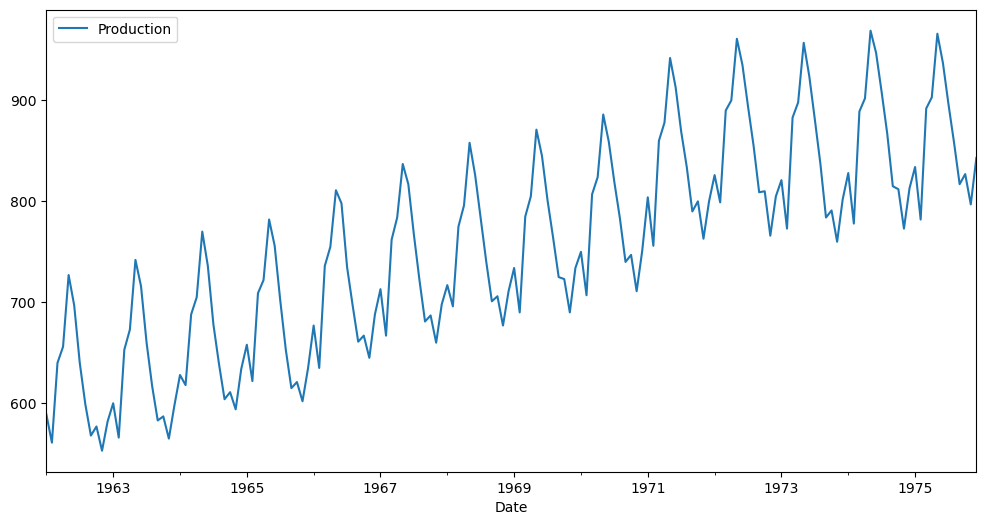

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
df.index.freq='MS'

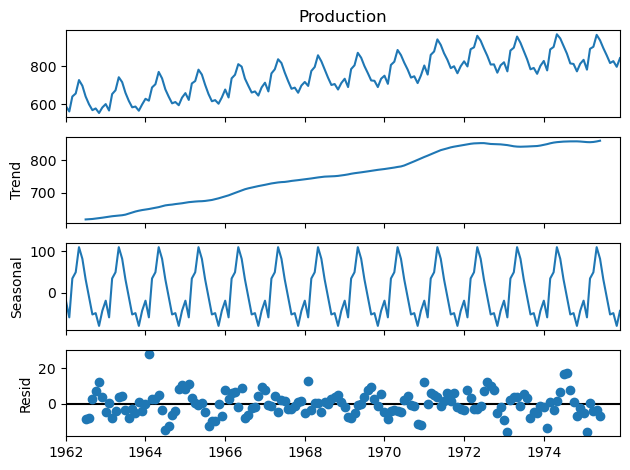

In [7]:
results=seasonal_decompose(df['Production'])
results.plot();

In [8]:
len(df)

168

In [9]:
train=df.iloc[:156]

In [10]:
test=df.iloc[156:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [12]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [13]:
scaler.fit(train)
scaled_train=scaler.transform(train)

In [14]:
scaled_test=scaler.transform(test)

In [15]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [16]:
# from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
n_inputs=3
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=1)

In [18]:
X,y=generator[0]
print(X.flatten())
print(y)

[0.08653846 0.01923077 0.20913462]
[[0.24759615]]


In [19]:
X.shape

(1, 3, 1)

In [20]:
n_inputs=12
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_inputs,batch_size=1)

In [21]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_inputs,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [23]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0450
Epoch 2/50
144/144 [==============================] - 1s 3ms/step - loss: 0.0186
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0154
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0117
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 9/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 10/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 11/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 12/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 13/50
144/144 [====

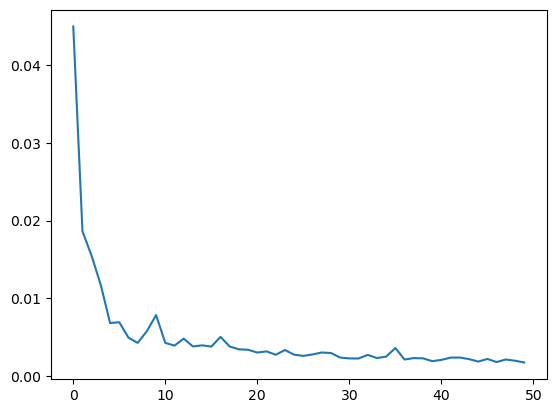

In [24]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
last_train_batch=scaled_train[-12:]

In [26]:
last_train_batch=last_train_batch.reshape((1,n_inputs,n_features))

In [27]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 129ms/step


array([[0.6659884]], dtype=float32)

In [28]:
scaled_test[0]

array([0.67548077])

In [30]:
test_pred=[]
first_eval_batch=scaled_train[-n_inputs:]
curr_batch=first_eval_batch.reshape((1,n_inputs,n_features))
for i in range(len(test)):
    curr_pred=model.predict(curr_batch)[0]
    test_pred.append(curr_pred)
    curr_batch=np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


In [31]:
test_pred

[array([0.6659884], dtype=float32),
 array([0.6212098], dtype=float32),
 array([0.8135599], dtype=float32),
 array([0.8719821], dtype=float32),
 array([0.99568903], dtype=float32),
 array([0.9750697], dtype=float32),
 array([0.8985206], dtype=float32),
 array([0.7984649], dtype=float32),
 array([0.6746888], dtype=float32),
 array([0.6379704], dtype=float32),
 array([0.5706034], dtype=float32),
 array([0.6236115], dtype=float32)]

In [32]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [33]:
true_pred=scaler.inverse_transform(test_pred)

In [34]:
test['Predictions']=true_pred

C:\Users\alok4\AppData\Local\Temp\ipykernel_39460\1680170604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_pred


<Axes: xlabel='Date'>

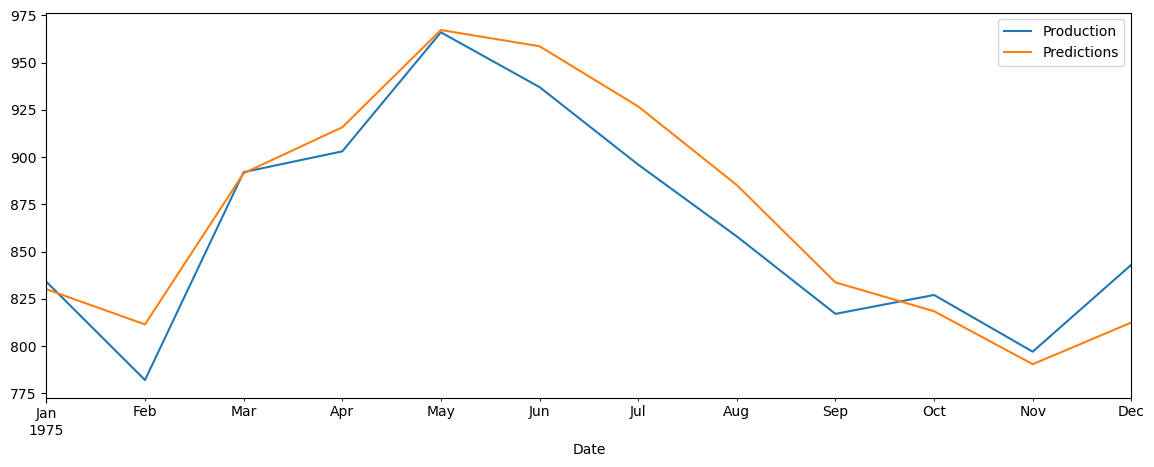

In [35]:
test.plot(figsize=(14,5))

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

19.428575221920447
